In [0]:

import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras import layers , activations , models , preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import preprocessing , utils
import os
import pandas as pd
from gensim.models import Word2Vec
import re

tf.__version__

'2.2.0-rc2'

In [0]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not Found')
# print('GPU at : {}'.format(device_name))

In [0]:

dir_path = '/content/file.csv'

dataset = pd.read_csv(dir_path)
data1 = dataset.loc[:,['human']]
data2 = dataset.loc[:,['reply']]
questions = [sent_list[0] for sent_list in data1.values]
answers = [sent_list[0] for sent_list in data2.values]

answers_with_tags = list()
for i in range( len( answers ) ):
    if type( answers[i] ) == str:
        answers_with_tags.append( answers[i] )
    else:
        questions.pop( i )

answers = list()
for i in range( len( answers_with_tags ) ) :
    answers.append( '<START> ' + answers_with_tags[i] + ' <END>' )

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))



VOCAB SIZE : 1593


In [0]:
answers

['<START> Namastae sir/mam. How can we help you? <END>',
 '<START> Please mention your username and the number sir/mam. <END>',
 '<START> How far are you from your router sir/mam? <END>',
 '<START> How many lights are glowing in your router? <END>',
 '<START> Can you please turn off the router and check after five minutes. <END>',
 '<START> welcome sir <END>',
 '<START> Hello sir/mam. How can we assist you? <END>',
 '<START> Sure sir/mam. The account number is 9801523053. <END>',
 '<START> Welcome and same to you sir/mam. <END>',
 '<START> Hello sir/mam. How can we assist you? <END>',
 '<START> Sure sir/mam. The account number is 9801523053. <END>',
 '<START> Welcome sir/mam. <END>',
 '<START> Hello sir/mam. The account number is 9801523053. <END>',
 '<START> Hello sir. How can we assist you? <END>',
 '<START> Sure sir. The account number is 9801523053. <END>',
 '<START> Welcome sir. Have a great day. <END>',
 '<START> Hello sir. How can we assist you? <END>',
 '<START> Sorry sir. <END

In [0]:



vocab = []
for word in tokenizer.word_index:
    vocab.append( word )

def tokenize( sentences ):
    tokens_list = []
    vocabulary = []
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = re.sub( '[^a-zA-Z]', ' ', sentence )
        tokens = sentence.split()
        vocabulary += tokens
        tokens_list.append( tokens )
    return tokens_list , vocabulary

p = tokenize( questions + answers )
model = Word2Vec( p[ 0 ] ) 

embedding_matrix = np.zeros( ( VOCAB_SIZE , 100 ) )








In [0]:
# encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [ len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions , maxlen=maxlen_questions , padding='post' )
encoder_input_data = np.array( padded_questions )
print( encoder_input_data.shape , maxlen_questions )

(629, 123) 123


In [0]:

# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

(629, 1393) 1393


In [0]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
onehot_answers = utils.to_categorical( padded_answers , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape )

(629, 1393, 1593)


In [0]:
encoder_inputs = tf.keras.layers.Input(shape=( None , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 200 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( None ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 200 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    318600      input_1[0][0]                    

In [0]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_4/cp.ckpt"
# checkpoint_path = "training_3/cp-{epoch:04d}.ckpt"


checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,verbose=1)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path)



In [0]:
history = model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=128, epochs=125,callbacks=[cp_callback] ) 




Train on 629 samples
Epoch 1/125
512/629 [=======================>......] - ETA: 4s - loss: 0.1761 - acc: 0.0705 
Epoch 00001: saving model to training_4/cp.ckpt
629/629 [==============================] - 25s 39ms/sample - loss: 0.1721 - acc: 0.0675
Epoch 2/125
512/629 [=======================>......] - ETA: 3s - loss: 0.1456 - acc: 0.0298
Epoch 00002: saving model to training_4/cp.ckpt
629/629 [==============================] - 21s 34ms/sample - loss: 0.1481 - acc: 0.0304
Epoch 3/125
512/629 [=======================>......] - ETA: 3s - loss: 0.1334 - acc: 0.0377
Epoch 00003: saving model to training_4/cp.ckpt
629/629 [==============================] - 21s 34ms/sample - loss: 0.1375 - acc: 0.0383
Epoch 4/125
512/629 [=======================>......] - ETA: 3s - loss: 0.1390 - acc: 0.0448
Epoch 00004: saving model to training_4/cp.ckpt
629/629 [==============================] - 21s 34ms/sample - loss: 0.1361 - acc: 0.0459
Epoch 5/125
512/629 [=======================>......] - ETA: 3s - l

from keras.models import load_model
model.load_weights(checkpoint_path)

model.summary()





In [0]:
# Re-evaluate the model
loss, acc  = model.evaluate([encoder_input_data , decoder_input_data], decoder_output_data,verbose=2)
print(" Accuracy: {:5.2f}%".format(100*acc))
print(" Loss: {:5.2f}%".format(100*loss))




629/629 - 21s - loss: 0.0304 - acc: 0.7255
 Accuracy: 72.55%
 Loss:  3.04%


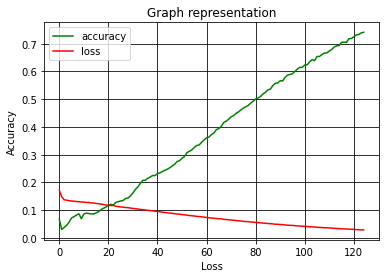

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'],color='green',label='accuracy')
plt.plot(history.history['loss'],color='red',label='loss')
plt.title('Graph representation')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.grid(True,color='k')
plt.legend(['accuracy', 'loss'])
plt.show()
# plt.plot(history.history['acc']

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


In [0]:


model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    318600      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    318600      input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [0]:
def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    
    for word in words:
        if word in vocab:
            tokens_list.append( tokenizer.word_index[ word ] )
        else:
            print(" ")
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')
  
            
        


In [0]:

    
enc_model , dec_model = make_inference_models()

while True:
    take = input( '> ' )
    
    states_values = enc_model.predict( str_to_tokens( take ) )
    if take == 'quit':
        break

    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word

        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True

        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 
        
    print( decoded_translation )


KeyboardInterrupt: ignored

In [0]:
hi